## Work in progress to sail the virtual ship

In [1]:
import json
import numpy as np
import pyproj
from datetime import timedelta
from shapely.geometry import Point, Polygon
from parcels import Field, FieldSet, JITParticle, Variable, ParticleSet

### Read sample input data

In [2]:
# Load the CMEMS data (3 weeks nov 2022 for IPO)
dataset_folder = "/nethome/0448257/Data"
filenames = {
    "U": f"{dataset_folder}/studentdata_UV_klein.nc",
    "V": f"{dataset_folder}/studentdata_UV_klein.nc",
    "S": f"{dataset_folder}/studentdata_S_klein.nc",
    "T": f"{dataset_folder}/studentdata_T_klein.nc"}  
variables = {'U': 'uo', 'V': 'vo', 'S': 'so', 'T': 'thetao'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time', 'depth': 'depth'}

# create the fieldset and set interpolation methods
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
fieldset.T.interp_method = "linear_invdist_land_tracer"
fieldset.S.interp_method = "linear_invdist_land_tracer"

# add bathymetry data to the fieldset for CTD cast
bathymetry_file = f"{dataset_folder}/GLO-MFC_001_024_mask_bathy.nc"
bathymetry_variables = ('bathymetry', 'deptho')
bathymetry_dimensions = {'lon': 'longitude', 'lat': 'latitude'}
bathymetry_field = Field.from_netcdf(bathymetry_file, bathymetry_variables, bathymetry_dimensions)
fieldset.add_field(bathymetry_field)
# read in data already
fieldset.computeTimeChunk(0,1)

21600

In [2]:
11*135

1485

In [2]:
# set initial location as lon-lat EW-NS #TODO should be input to function or come from leafmap 
coords_input = [[-83.737793, 3.591884], [-86.879883, 4.258768], [-86.879883, -0.747049], [-86.791992, -4.740675], [-86.791992, -9.058702]]
ctd_input = [[-83.737793, 3.591884], [-86.879883, 4.258768], [-86.879883, -0.747049], [-86.791992, -4.740675], [-86.791992, -9.058702]]
drifter_input = [[-83.737793, 3.591884], [-83.737793, 3.591984], [-83.737893, 3.591884]]
coords_input = [[-80, 2], [-80.01, 2], [-90, 2], [-100, 2], [-110, 2], [-120, 2], [-125, 2.5], [-115, 2.5], [-105, 2.5], [-95, 2.5], [-85, 2.5]]
# coords_input = [[-82.924805, 4.696879], [-84.418945, 3.908099], [-86.044922, 3.074695], [-87.978516, 2.021065], [-90, 1.274309], [-91.977539, 0.483393], [-92.021484, -1.054628], [-90.65918, -2.021065], [-88.769531, -1.054628], [-86.879883, 0], [-84.990234, 1.098565], [-83.320313, 2.021065], [-81.650391, 3.513421], [-80.244141, 4.784469]]
# coords_input = [[152.8, 36.6], [156.6, 36.9]]

### Determine ship course as intermediate points between CTD stations

In [4]:
# Initialize lists to store intermediate points
lons = []
lats = []

# Loop over station coordinates and calculate intermediate points along great circle path
i = 0
for i in (range(len(coords_input)-1)):
    startlong = coords_input[i][0]
    startlat = coords_input[i][1]
    endlong = coords_input[i+1][0]
    endlat = coords_input[i+1][1]

    # calculate line string along path with segments every 5 min = 3.6*60*5 = 1080 m (or switch comment for 2 midpoints)
    geod = pyproj.Geod(ellps='WGS84')
    r = g.inv_intermediate(startlong, startlat, endlong, endlat, del_s=1080, initial_idx=0, return_back_azimuth=False)
    # r = g.inv_intermediate(startlong, startlat, endlong, endlat, initial_idx=0, return_back_azimuth=False, npts=3)
    lons = np.append(lons, r.lons) # stored as a list of arrays
    lats = np.append(lats, r.lats)

    # initial_idx will add begin point to each list (but not end point to avoid dubbling) so add final endpoint manually
    lons = np.append(np.hstack(lons), endlong)
    lats = np.append(np.hstack(lats), endlat)



(-89.99982550251605, 89.99982550251605, 1112.521315199904)
(-89.8252315914032, 89.8252315914032, 1111407.073934867)
(-89.82505575223266, 89.82505575223266, 1112519.5900692847)
(-89.82505575223266, 89.82505575223266, 1112519.5900692847)
(-89.82505575223266, 89.82505575223266, 1112519.5900692847)
(-84.22838722804681, 95.5751864989223, 558910.4685414702)
(89.78134505877674, -89.78134505877674, 1112139.781805734)
(89.78134505877674, -89.78134505877674, 1112139.781805734)
(89.78134505877674, -89.78134505877674, 1112139.781805734)
(89.78134505877674, -89.78134505877674, 1112139.781805734)


In [ ]:
# check if input sample locations are within data availability area, only save if so
poly = Polygon([(-170, 5), (-170, -10), (-75, -10), (-75, 5)])
ctd_coords = []
drifter_coords = []
sample_lons = []
sample_lats = []
for coord in ctd_input:
    if poly.contains(Point(coord)):
        ctd_coords.append(coord)
for coord in drifter_input:
    if poly.contains(Point(coord)):
        drifter_coords.append(coord)
for i in range(len(lons)):
    if poly.contains(Point(lons[i], lats[i])):
        sample_lons.append(lons[i])
        sample_lats.append(lats[i])

### Define particles and sampling functions 

In [12]:
# Create ADCP like particles to sample the ocean
class ADCPParticle(JITParticle):
    """Define a new particle class that does ADCP like measurements"""
    U = Variable('U', dtype=np.float32, initial=0.0)
    V = Variable('V', dtype=np.float32, initial=0.0)

# define ADCP sampling function without conversion (because of A grid)
def SampleVel(particle, fieldset, time):
    particle.U, particle.V = fieldset.UV.eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)
    # particle.V = fieldset.V.eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)

# Create particle to sample water underway
class UnderwayDataParticle(JITParticle):
    """Define a new particle class that samples water directly under the hull"""
    salinity = Variable("salinity", initial=np.nan)
    temperature = Variable("temperature", initial=np.nan)

# Create CTD like particles to sample the ocean
class CTDParticle(JITParticle):
    """Define a new particle class that does CTD like measurements"""
    salinity = Variable("salinity", initial=np.nan)
    temperature = Variable("temperature", initial=np.nan)
    pressure = Variable("pressure", initial=np.nan)
    raising = Variable("raising", dtype=np.int32, initial=0.0)

# define function lowering and raising CTD
def CTDcast(particle, fieldset, time):
    seafloor = fieldset.bathymetry[time, particle.depth, particle.lat, particle.lon]
    vertical_speed = 1.0  # sink and rise speed in m/s

    if particle.raising == 0:
        # Sinking with vertical_speed until near seafloor
        particle_ddepth = vertical_speed * particle.dt
        if particle.depth >= (seafloor - 20): 
            particle.raising = 1

    if particle.raising == 1:
        # Rising with vertical_speed until depth is 2 m
        if particle.depth > 2:
            particle_ddepth = -vertical_speed * particle.dt  
            if particle.depth + particle_ddepth <= 2:
                # to break the loop ...
                particle.state = 41
                print("CTD cast finished")

# define function sampling Salinity
def SampleS(particle, fieldset, time):
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]

# define function sampling Temperature
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

# define function sampling Pressure
def SampleP(particle, fieldset, time):
    particle.pressure = fieldset.P[time, particle.depth, particle.lat, particle.lon]

### Run simulation

In [45]:
# Create ADCP like particleset and output file
ADCP_bins = np.arange(5, 1000, 24)
vert_particles = len(ADCP_bins)
pset_ADCP = ParticleSet.from_list(
    fieldset=fieldset, pclass=ADCPParticle, lon=np.full(vert_particles,sample_lons[0]), lat=np.full(vert_particles,sample_lats[0]), depth=ADCP_bins, time=0
)
adcp_output_file = pset_ADCP.ParticleFile(name="./results/sailship_ADCP.zarr")
adcp_dt = timedelta(minutes=5).total_seconds() # timestep of ADCP output, every 5 min == 1080 m (3.6*60*5 =m/s*s/min*min)

# Create underway particle 
pset_UnderwayData = ParticleSet.from_list(
    fieldset=fieldset, pclass=UnderwayDataParticle, lon=sample_lons[0], lat=sample_lats[0], depth=2, time=0
)
UnderwayData_output_file = pset_UnderwayData.ParticleFile(name="./results/sailship_UnderwayData.zarr")

# initialize CTD station number and time 
total_time = timedelta(hours=0).total_seconds()
ctd = 0
ctd_dt = timedelta(seconds=10) # timestep of CTD output reflecting post-proces binning into 10m bins

# initialize drifters and floats
drifter = 0
drifter_time = []

# run the model for the length of the sample_lons list
for i in range(len(sample_lons)-1):

    # execute the ADCP kernels to sample U and V and underway T and S
    pset_ADCP.execute(SampleVel, dt=adcp_dt, runtime=1, verbose_progress=False) 
    adcp_output_file.write(pset_ADCP, time=pset_ADCP[0].time)
    pset_UnderwayData.execute([SampleS, SampleT], dt=adcp_dt, runtime=1, verbose_progress=False)
    UnderwayData_output_file.write(pset_UnderwayData, time=pset_ADCP[0].time)

    # check if we are at a CTD station
    if (sample_lons[i] - ctd_coords[ctd][0]) < 0.001 and (sample_lats[i] - ctd_coords[ctd][1]) < 0.001:
        ctd += 1
        
        # release CTD particle
        pset_CTD = ParticleSet(fieldset=fieldset, pclass=CTDParticle, lon=sample_lons[i], lat=sample_lats[i], depth=2, time=total_time)

        # create a ParticleFile to store the CTD output
        ctd_output_file = pset_CTD.ParticleFile(name=f"./results/CTD_test_{ctd}.zarr", outputdt=ctd_dt)

        # record the temperature and salinity of the particle
        pset_CTD.execute([SampleS, SampleT, CTDcast], runtime=timedelta(hours=4), dt=ctd_dt, output_file=ctd_output_file)
        total_time = pset_CTD.time[0] + timedelta(hours=1).total_seconds() # add CTD time and 1 hour for deployment

    # check if we are at a drifter deployment location
    if drifter < len(drifter_coords):
        while (sample_lons[i] - drifter_coords[drifter][0]) < 0.001 and (sample_lats[i] - drifter_coords[drifter][1]) < 0.001:
            drifter += 1
            drifter_time.append(total_time)

    # update the particle time and location
    pset_ADCP.lon_nextloop[:] = sample_lons[i+1]
    pset_ADCP.lat_nextloop[:] = sample_lats[i+1]
    pset_UnderwayData.lon_nextloop[:] = sample_lons[i+1]
    pset_UnderwayData.lat_nextloop[:] = sample_lats[i+1]    
    
    total_time += adcp_dt
    pset_ADCP.time_nextloop[:] = total_time
    pset_UnderwayData.time_nextloop[:] = total_time
    if i % 48 == 0:
        print(f"Gathered data {pset_ADCP[0].time/3600} hours since start")

# write the final locations of the ADCP and Underway data particles
pset_ADCP.execute(SampleVel, dt=adcp_dt, runtime=1, verbose_progress=False)
adcp_output_file.write_latest_locations(pset_ADCP, time=total_time)
pset_UnderwayData.execute([SampleS, SampleT], dt=adcp_dt, runtime=1, verbose_progress=False)
UnderwayData_output_file.write_latest_locations(pset_UnderwayData, time=total_time)

INFO: Output files are stored in ./results/CTD_test_1.zarr.
 40%|███▉      | 5690.0/14400.0 [03:40<10:07, 14.34it/s]CTD cast finished
 40%|███▉      | 5690.0/14400.0 [03:40<05:36, 25.85it/s]


IndexError: list index out of range

In [48]:
drifter_time

[9290.0, 9290.0, 9290.0, 9290.0, 9290.0, 9290.0]

In [3]:
import xarray as xr
# Open output and read to x, y, z
ds = xr.open_zarr("../results/sailship_ADCP.zarr")
time = ds["time"][0].values
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
ds.close()

In [8]:
ds.V[1:10].values

array([[ 0.21141048,  0.21073838,  0.21154574, ..., -0.05740462,
        -0.05878886, -0.06029826],
       [ 0.22115852,  0.22025768,  0.22080159, ..., -0.06844132,
        -0.07026841, -0.07221974],
       [ 0.23090656,  0.229777  ,  0.23005745, ..., -0.07947803,
        -0.08174795, -0.08414122],
       ...,
       [ 0.15958248,  0.15866159,  0.16019139, ..., -0.16439535,
        -0.16591409, -0.16754586],
       [ 0.13169025,  0.13092402,  0.13297619, ..., -0.1893431 ,
        -0.19044396, -0.19165468],
       [ 0.10379802,  0.10318644,  0.10576099, ..., -0.21429083,
        -0.21497384, -0.2157635 ]], dtype=float32)

NameError: name 'ax' is not defined

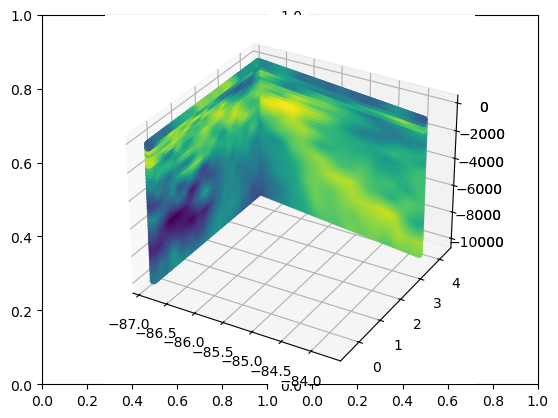

In [9]:
import matplotlib.pyplot as plt
# Plot Particle depth
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = plt.axes(projection="3d")
ax2 = plt.axes(projection="3d")
cu = ax1.scatter(x, y, z*10, c=U, s=20, marker="o")
cv = ax2.scatter(x, y, z*10, c=V, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

In [11]:
import xarray as xr
import numpy as np
from scipy.ndimage import uniform_filter1d

ctd = 10
# rewrite CTD data to cvs
for i in range(1, ctd):
    
    # Open output and read to x, y, z
    ds = xr.open_zarr(f"../results/CTD_{i}.zarr")
    x = ds["lon"][:].squeeze()
    y = ds["lat"][:].squeeze()
    z = ds["z"][:].squeeze()
    time = ds["time"][:].squeeze()
    T = ds["temperature"][:].squeeze()
    S = ds["salinity"][:].squeeze()
    ds.close()

    # add some noise
    random_walk = np.random.random()/10
    z_norm = (z-np.min(z))/(np.max(z)-np.min(z))
    t_norm = np.linspace(0, 1, num=len(time))
    # dS = abs(np.append(0, np.diff(S))) # scale noise with gradient
    # for j in range(5, 0, -1):
    #     dS[dS<1*10**-j] = 0.5-j/10
    # add smoothed random noise scaled with depth (and OPTIONAL with gradient for S) 
    # and random (reversed) diversion from initial through time scaled with depth 
    S = S + uniform_filter1d(
        np.random.random(S.shape)/5*(1-z_norm) + 
        random_walk*(np.max(S).values - np.min(S).values)*(1-z_norm)*t_norm/10, 
        max(int(len(time)/40), 1))
    T = T + uniform_filter1d(
        np.random.random(T.shape)*5*(1-z_norm) - 
        random_walk/2*(np.max(T).values - np.min(T).values)*(1-z_norm)*t_norm/10, 
        max(int(len(time)/20), 1))

    # reshaping data to export to csv
    header = f"'pressure [hPa]','temperature [degC]', 'salinity [g kg-1]'"
    data = np.column_stack([(z/10), T, S])
    new_line = '\n'
    np.savetxt(f"../results/CTD_station_{i}.csv", data, fmt="%.4f", header=header, delimiter=',', 
               comments=f'{x.attrs}{new_line}{x[0].values}{new_line}{y.attrs}{new_line}{y[0].values}{new_line}start time: {time[0].values}{new_line}end time: {time[-1].values}{new_line}')


FileNotFoundError: No such file or directory: '/storage/home/0448257/Virtual_ship_classroom/results/CTD_3.zarr'

In [13]:
lon = []
lat = []
with open('../results/CTD_station_2.csv', 'r') as file:
    text = file.read().splitlines()
lon.append(text[1])
lat = text[3]
lon, lat

(['-86.8798828125'], '4.258768081665039')

In [16]:
# Some sample code you can use, you only have to replace the <...> instances to make it work
lon = []
lat = []
z20 = []

import numpy as np
for i in range(1, 2):
    with open(f'../results/CTD_station_{i}.csv', 'r') as file:
        station_data = file.read().splitlines()
    lon.append(station_data[1])
    lat.append(station_data[3])

    P, T, S = np.loadtxt(f'../results/CTD_station_{i}.csv', delimiter=',', skiprows=7, unpack=True)
    z20.append(P[T<20][0])

In [15]:
# z20 = P[T<20][0]
z20

[7.2, 9.2, 8.2]

<Axes: >

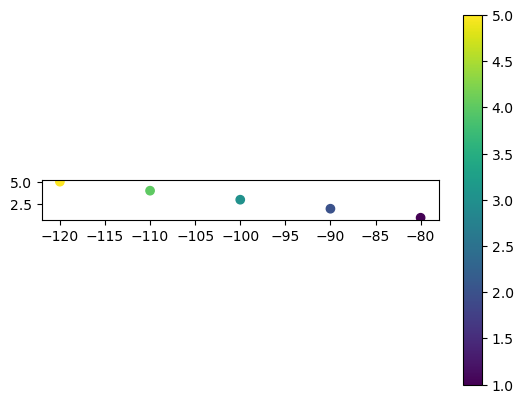

In [17]:
lat = [1, 2, 3, 4, 5]
lon = [-80, -90, -100, -110, -120]
z20 = [1, 2, 3, 4, 5]
import pandas as pd
import geopandas as gpd
df = pd.DataFrame({'lat': lat, 'lon': lon, 'z20': z20})
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lon, lat))  
gdf.plot(column='z20', legend=True)

ModuleNotFoundError: No module named 'cloupy'

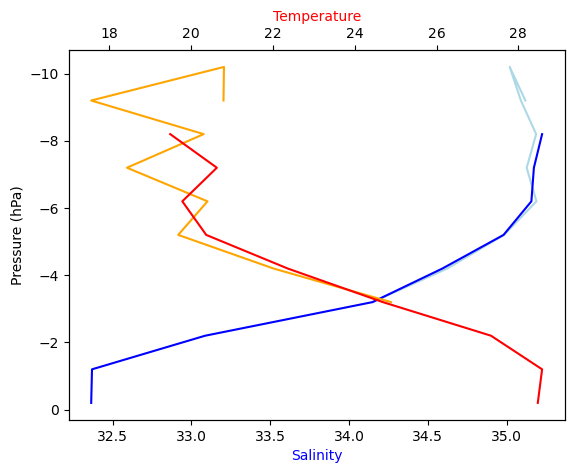

In [23]:
# Read back in... student example
import numpy as np
z, T, S = np.loadtxt('../results/CTD_station_1.csv', delimiter=',', skiprows=7, unpack=True)

# TS plot
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1)
ax1.plot(S[int(len(z)/2):-1], z[int(len(z)/2):-1], color="lightblue")
ax1.plot(S[0:int(len(z)/2)], z[0:int(len(z)/2)], color="b")
ax1.invert_yaxis()
ax1.set_xlabel('Salinity', color = "b")
ax1.set_ylabel('Pressure (hPa)')
ax2 = ax1.twiny() # ax1 and ax2 share y-axis
ax2.set_xlabel('Temperature', color = "r")
ax2.plot(T[int(len(z)/2):-1], z[int(len(z)/2):-1], color="orange")
ax2.plot(T[0:int(len(z)/2)], z[0:int(len(z)/2)], color="r") 
plt.show()

In [18]:
# Some sample code you can use
lon = []
lat = []
z20 = []

for i in range(1, 10):
    with open(f'./results/CTD_station_{i}.csv', 'r') as file:
        station_data = file.read().splitlines()
    lon.append(station_data[1])
    lat.append(station_data[3])

    P, T, S = np.loadtxt(f'./results/CTD_station_{i}.csv', delimiter=',', skiprows=7, unpack=True)
    z20.append(P[T < 20][0])

# Look up or calculate z20 or plot the profile and determine from there
z20

[7.2, 7.2, 9.2, 11.2, 15.2, 15.2, 15.2, 15.2, 15.2]

<Axes: >

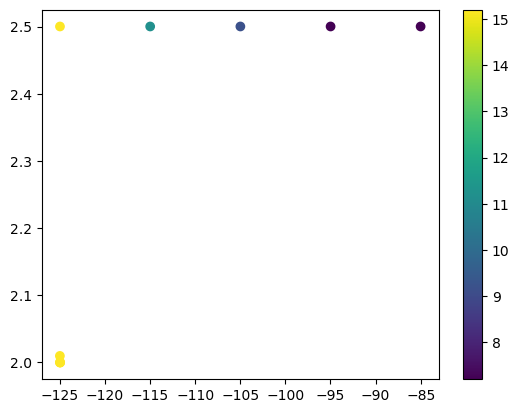

In [22]:
import pandas as pd
import geopandas as gpd

df = pd.DataFrame({'lat': lat, 'lon': lon, 'z20': z20})
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lon, lat))
gdf.plot(column='z20', legend=True, aspect=None) #try aspect='equal' if your map is distorted

In [37]:
# Warm Water Volume - East (5°N-5°S, 120°W-80°W)
(40 * 111000) * (10 * 111000) * 130 / 1e15 

0.640692

In [ ]:
https://colab.research.google.com/drive/1dabU91WECy5cglb2mVC-8SG4muFNlQrw?usp=sharing